# Pattern matching


We will start in the same way as the last notebook started  - by downloading/importing the packages needed and importing the .csv file(s) needed. In this case, we only need the .csv file that has the matched abstracts as we are specifically looking at person-first and identity-first patterns that are "about" autism (or ASD, Asperger's syndrome, etc.). 

We could use the same basic approach to look at person-first and identity-first language for other conditions for which there are good noun and adjective forms of the words (diabetes? obesity? cancer? something else?). Doing that would mean using the .csv file with all of the abstracts or potentially creating and entirely new file of abstracts matched to another condition of interest. However, that lies outside the scope of this research, so I will not address it further here. 

## Get ready 

As always, we start with a couple of code cells that load up and nickname some useful packages, then check file locations, then import files and check them. 

In [1]:
%%capture

# installing necessary pdf conversion packages via pip
# the '%%capture' at the top of this cell suppresses the output (which is normally quite long and annoying looking). 
# You can remove or comment it out if you prefer to see the output. 
!pip install nltk
!pip install spacy -q
!python -m spacy download en_core_web_lg -q


In [79]:
%%capture

import os                         # os is a module for navigating your machine (e.g., file directories).
import nltk                       # nltk stands for natural language tool kit and is useful for text-mining. 
from nltk import word_tokenize    # and some of its key functions
from nltk import sent_tokenize  
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from nltk.corpus import wordnet                    # Finally, things we need for lemmatising!
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
nltk.download('averaged_perceptron_tagger')        # Like a POS-tagger...
nltk.download('wordnet')
nltk.download('webtext')
from nltk.corpus import webtext

import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import statistics

import csv                        # csv is for importing and working with csv files

from collections import Counter

import statistics
import re                         # things we need for RegEx corrections
import string 
import spacy 
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 1500000 #or any large value, as long as you don't run out of RAM

import math
import matplotlib.pyplot as plt


In [3]:
print(os.listdir("..\\output")  )      

['all_abstracts_no_null_texts.csv', 'matched_abstracts_no_null_texts.csv', 'most_frequent_comparison.csv', 'pattern_matches_reviewed.csv', 'pattern_matches_to_review.csv']


## Import

Having checked the contents of the output folder and seen the files we expected to see, we can now import the specific file of interest for this step of the analysis.

In [4]:
matched_texts = pd.read_csv('..\\output\\matched_abstracts_no_null_texts.csv')    # one for just those that match the keyword
len(matched_texts)                                                                # check the length 

906

## Cleaning phase

Cleaning begins by turning any instances of extra whitespaces (two or more in a row) into a single whitespace. Then, identifying any run-on sentences (where a lowercase letter, a full stop, and an uppercase letter are clustered without a whitespace) and inserting a whitespace between the full stop and the uppercase letter. Both of these steps will improve the sentence tokenisation that happens next. 

Then, we proceed to sentence tokenising the text. Like word tokens, sentence tokens become the unit for analysisis. As a trivial example, sentence tokenisation would turn a short text such as 


''' The cat named Cat is one of five cats. Honestly, I wonder why I have so many cats.
''' 

into a list of sentence tokens like

''' [[The cat named Cat is one of five cats.]

[Honestly, I wonder why I have so many cats.]]

''' 

An important difference is that the punctuation within the sentences that contributes to its structured and meaning (e.g. the comma and the full stops) are retained. This punctuation, like the capitalisation at the start of the sentences or for the poper nouns, is also retained as it helps the sentence-tokenisation process identify the words within the sentence correctly for their parts of speech (e.g. which of the words are nouns, verbs, etc. ). 



The sentence tokens are then put on individual rows, filtered to retain only those that contain one or more of the keywords of interest, and then filtered to ensure that there are no empty rows or duplicates. 

In [5]:
test_string = "Testing.Run-on removal.   Extra whitespace removal. "

def remove_errors (input):
    no_extra_spaces = re.sub(r'(\s)(\s+)', r'\1', input)               # turn 2+ sequential whitespaces into 1
    no_run_ons = re.sub(r'([a-z].)([A-Z])', r'\1 \2', no_extra_spaces) # identifies run-ons (e.g. "word.New sentence ")
    
    return(no_run_ons)

remove_errors(test_string)

'Testing. Run-on removal. Extra whitespace removal. '

In [6]:
no_run_ons = [remove_errors(abstract) for abstract in matched_texts['Text'] ] 
                                             # create abstract list without extra spaces/run-ons 
                                             # this is to improve sentence tokenisation later
len(no_run_ons)                              # always good to keep an eye on numbers

906

In [7]:
matched_texts['Sentence'] = no_run_ons        # copy the no extra space/run-on abstract list back into df as a new column

In [8]:
sentences  = [sent_tokenize(abstract) for abstract in matched_texts['Sentence'] ] # create tokenised list of cleaner abstracts
matched_texts['Sentence'] = sentences                                   # copy that list back into df as a new column
sentence_per_row = matched_texts.explode('Sentence')                    # explode column in new df with 1 row/sentence token
len(sentence_per_row)                                                   # check the length of new df


14067

In [9]:
sentence_per_row                                                    # have a look. For the first two rows, 
                                                                    # 'Text' should be same, but 'Sentence' should not

,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes.
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) the shift of the double bond from C8 9to C7 8(3ÃÂ§ sterol D 8 D7isomerase/ EBP E.C.
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,5.3.3.5) and the removal of the double bond at C7 8(D7 sterol reduc tase/ DHCR7 E.C.
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,1.3.1.21).
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,Missense and nonsense mutations in NSHDL on Xq28 cause X chromosomal dominant CHILD syndrome (congenitalhemidysplasia with ichthyosiform erythroderma and limb defects MIM308050) a rare inborn...
...,...,...,...,...,...,...,...,...,...,...
905,2158,NaN,NaN,NaN,P0833Screening for ARX gene mutations is indicated for males problems. The study of this disorder has intensiÜed because with mental retardation associated with West syndrome and/or incidence i...,2004.0,NaN,NaN,NaN,This duplication patients 49 returned with completed metabolic work up.
905,2158,NaN,NaN,NaN,P0833Screening for ARX gene mutations is indicated for males problems. The study of this disorder has intensiÜed because with mental retardation associated with West syndrome and/or incidence i...,2004.0,NaN,NaN,NaN,In this group leads to an expansion of a polyalanine tract in the ARX protein.
905,2158,NaN,NaN,NaN,P0833Screening for ARX gene mutations is indicated for males problems. The study of this disorder has intensiÜed because with mental retardation associated with West syndrome and/or incidence i...,2004.0,NaN,NaN,NaN,"of 49 patients 18 had a diagnosis of autism and 31 of PDD, only one The ARX gene was screened for mutations in Üve males with mental patient was female, average age was 5.4 years."
905,2158,NaN,NaN,NaN,P0833Screening for ARX gene mutations is indicated for males problems. The study of this disorder has intensiÜed because with mental retardation associated with West syndrome and/or incidence i...,2004.0,NaN,NaN,NaN,Sixty percent of the retardation associated with West syndrome and/or dysto

In [10]:
matched_sentences = sentence_per_row[sentence_per_row['Sentence'].str.contains('[Aa]utis|ASD|[Aa]sperger')]
                                                     # create a new data frame with only the sentences that contain keywords
len(matched_sentences)                               # check the length

2092

In [11]:
matched_sentences = matched_sentences[~matched_sentences['Sentence'].isnull()]  # remove any rows with empty 'Sentence' column
matched_sentences = matched_sentences.drop_duplicates()                         # drop any duplicates
len(matched_sentences)                                                          # check length of remaining data frame

2092

In [12]:
matched_sentences

,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,syndactyly heart and lungdefects) failure to thrive and mental retardation or autism.
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with s...
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Itis characterised by difficulties in social interaction and stereotyped behav iour but in contrast to infantile autism by normal intelligence and usuallynormal language skills.
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,In the pediatric age group the prevalence of Asperger syndrome is around 4 7/1000 whereas the corresponding figurefor the infantile autism is 4/10000.
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Based on clinical observations AS is inherited in the same families as infantile autism but also as a sepa rate entity often transmitted from male to male.
...,...,...,...,...,...,...,...,...,...,...
904,2157,NaN,NaN,NaN,"P0835Presence of elevated lactate, lactate/pyruvate ratio and Analysis of the patientsÓclinical and molecular data demonstrated that acylcarnitine proÜle in patients with autism. all Üve patient...",2004.0,NaN,NaN,NaN,"P0835Presence of elevated lactate, lactate/pyruvate ratio and Analysis of the patientsÓclinical and molecular data demonstrated that acylcarnitine proÜle in patients with autism."
904,2157,NaN,NaN,NaN,"P0835Presence of elevated lactate, lactate/pyruvate ratio and Analysis of the patientsÓclinical and molecular data demonstrated that acylcarnitine proÜle in patie

## Extraction

Following the cleaning phase, we move on to the extraction phase. This has two parts, first for the person-first extraction and then for the identity-first extraction. 

The results of both extractions are saved in their own column to make it easy to read and also to allow for a single sentence-token to contain both kinds of patterns. 

### Person-first pattern

In [13]:
pattern_2 = [{"POS": "NOUN"},                                                   # define the person-first pattern(s)
             {'LOWER': 'with'},                                                 # I made 3 for clarity rather than one with 
             {'DEP':'amod', 'OP':"?"},                                          # a real complex regex string
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"TEXT": {"REGEX": "^[Aa]utism$"}}]

pattern_3 = [{"POS": "NOUN"},
             {'LOWER': 'with'},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"TEXT": {"REGEX": "^[Aa]sperger$"}}]

pattern_4 = [{"POS": "NOUN"},
             {'LOWER': 'with'},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"TEXT": {"REGEX": "^ASD$"}}]

# Matcher class object 
matcher = Matcher(nlp.vocab)                                                  # define a matcher class object
matcher.add("matching_1", [pattern_2, pattern_3, pattern_4])                  # add my three person-first patterns to it

In [14]:
def find_pattern_match(input):                                               # define a function that applies the person-first
    thingy = nlp(input)                                                       # matcher class object to strings
    match = matcher(thingy)                                                   # and returns any matches to the pattern(s)
    if match == []:
        out_value = ''
    else:
        hold_multi_spans = []
        for match_id, start, end in match:
                string_id = nlp.vocab.strings[match_id]  # Get string representation
                span = thingy[start:end]  # The matched span
                hold_multi_spans.append(span)
        out_value = hold_multi_spans
    return out_value

In [15]:
matched_sentences['Person-first'] = matched_sentences.apply(lambda row: find_pattern_match(row.Sentence), axis = 1)
                                                                        # apply the newly defined person-first matcher function
                                                                        # and store the returned output in a new column
len(matched_sentences)                                                  # double check length remains same

2092

### Identity-first pattern

In [16]:
pattern_a = [{"TEXT": {"REGEX": "^[Aa]utistic"}},                        # do the same for identity-first patterns
             {'DEP':'amod', 'OP':"?"},                                   # again, i wrote 3 patterns for clarity sake
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"POS": "NOUN"}]

pattern_b = [{"TEXT": {"REGEX": "^[Aa]sperger"}},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"POS": "NOUN"}]

pattern_c = [{"TEXT": {"REGEX": "^ASD"}},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"POS": "NOUN"}]

# Matcher class object                                         
matcher = Matcher(nlp.vocab) 
matcher.add("matching_2", [pattern_a, pattern_b, pattern_c])            # this overwrites the matcher object to identity-first

In [17]:
matched_sentences['Identity-first'] = matched_sentences.apply(lambda row: find_pattern_match(row.Sentence), axis = 1)
                                                                        # apply the newly overwritten matcher function
                                                                        # and store the returned output in a new column
len(matched_sentences)                                                  # check the length - why not?

2092

### Consolidation

Following the cleaning and extraction phases, the last phase is consolidation. This phase further refines the data by removing all the rows that do not contain a match for one or both of the patterns. For example, there would be a row for "The child was tested for autism." because it contains a keyword of interest. However, this sentence would be eliminated in the consolidation phase as the keyword does not fit into either the person-first or identity-first patterns. 

Further, this phase goes on to lemmatise the extracted patterns so that they can be counted more easily. This phase also lowercases all occurrences of "Autistic", "Autism", and "Asperger's" as well as removing the apostrophe, the 's' and any non-white characters that might intrude between the 'r' and the 's' of "Asperger's". This phase also removes any square brackets, quotes and extra commas introduced by the lemmatisation process. 

This phase ends by writing out the consolidated data frame to a .csv for manual inspection. I could not find a feasible way of identifying whether or not the nouns matched in the extraction phase are person-nouns or not. As the list is not a totally unreasonable length (in the hundreds) I found it workable to 
* open in excel, 
* save the file under another name (e.g. pattern_matches_reviewed), 
* order the entire data set alphabetically by 'Person-first', 
* scan through the ordered results check whether each result in the 'Person-first' column is about a person, 
* removing entire rows if the 'Person-first' match is not about a person (checking the 'Sentence' or 'Text' column if needed)
* re-order the entire data set alphabetically by 'Identity-first', 
* scan through the ordered results check whether each result in the 'Identity-first' column is about a person, 
* removing entire rows if the 'Identity-first' match is not about a person, 
* save file again. 

For example, 'association with autism' matches the person-first pattern but is not about a person, so this row was removed. Many more rows were removed in the 'Identity-first' matches as things like 'autistic behaviours' and 'autism testing' were removed for not being about people. 

NOTE: There were several instances of "ASD dataset" which are not easy to determine if they are about people or not. Do they mean dataset composed from blood tests taken as part of ASD testing? If so, each row in the data set would be a blood test with the possibility that more than one test comes from the same person. Or do they mean a pool of case records, each of which represents a single person? The former would not be "about people" but the second would. I did not remove these rows as we cannot be certain. Leaving them out would also have been a valid option, as long as the choice was clear. 

Coincidentally, during this manual checking part of the consolidation phase I learned that, in the context of human genetics research "proband" is a person-noun. 

In [18]:
matched_patterns = matched_sentences[(matched_sentences['Person-first'] != '') | (matched_sentences['Identity-first'] != '')]
                                                     # keep only rows w/ non-null 'Person-first' and/or 'Identity-first' columns
len(matched_patterns)                                # check length

647

In [19]:
matched_patterns = matched_patterns.explode('Person-first')    # explode 'Person-first' column to create 1 row per match
                                                               # if there were two matches within the same sentence
len(matched_patterns)                                          # check the length

648

In [20]:
matched_patterns = matched_patterns.explode('Identity-first')  # Do the same for 'Identity-first' column
len(matched_patterns)                                          # check the length

681

In [21]:
matched_patterns                                               # have a look at them

,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with s...,,"(Asperger, syndrome)"
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with s...,,"(autistic, psychopa)"
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,In the pediatric age group the prevalence of Asperger syndrome is around 4 7/1000 whereas the corresponding figurefor the infantile autism is 4/10000.,,"(Asperger, syndrome)"
5,443,Preliminary Findings In The Diagnostic Evaluation Of A Sample Of 103 Individuals With Pervasive DevelopmentDisorders,P0341.,E. Steiner M. M. Guerreiro A. P. Marques de Faria Unicamp Campinas B,Pervasive development disorders (PDD) are a heterogeneous group ofneurobehavioral disorders of infancy. In order to identify etiologic factors ina sample of individuals with PDD a total of 103 su...,2001.0,dgmfcm@unicamp.br,NaN,NaN,In order to identify etiologic factors ina sample of individuals with PDD a total of 103 subjects (84 males and 19females) referred for autistic behavior were submitted to a protocol includ ing c...,,"(autistic, behavior)"
7,473,Detection of subtelomeric rearrangements by FISH in patients with idiopathic mental retardation or autism.,P0372.,Ostergaard J. M. Hahnemann H. Hjalgrim K. Nielsen H. M. Nielsen K. Brondum NielsenJohn F. Kennedy Institute Glostrup D,The subtelomeric regions are often involved in chromosomal rearrange 172 Posters: Clinical Genetics and Dysmorphologyments. They are gene rich and therefore rearrangements in these regions are mor...,2001.0,els@kennedy.dk,NaN,NaN,Two groups of patients all with normal standard chromosome analysis were investigated One group consisted of 14 patients with autism andwith at least one other relative affected with autism.,"(patients, with, autism)",
...,...,...,...,...,...,...,...,...,...,...,...,...
895,395,NaN,NaN,NaN,"P0107An additional case of the KBG syndrome 1Department of Pediatrics, University of Tartu, Tartu, Estonia, 2TallinnÓs Children B. Demeer1, N. Bednarek2, Z. Belkadi3, M. Khoury3, C. Eschard4, D. ...",2004.0,NaN,NaN,NaN,In developmental delay with speech defect and au

In [36]:
Lem = WordNetLemmatizer()                         # Define a short way to call the WordNetLemmatizer

In [37]:
def consolidate_matched_patterns (input):         # 
    final_lemma_list = []
    temp_lemma_list = []
    for phrase in input:                       # start for loop looking at each pattern in the person-first pattern column
        phrase_as_string = str(phrase)                               # hold the current pattern
        words_in_phrase = phrase_as_string.split() # split the current pattern into words
        for word in words_in_phrase :                            # for each word in the split up words
            lemma = Lem.lemmatize(word)             # turn that word into a lemma
            temp_lemma_list.append(lemma)                # append that lemma to a temporary list
        string_lem = str(temp_lemma_list)              # turn that temporary list into a string
        stripped_lem = re.sub(r"\[|\]|\'|\,",'', string_lem)  # remove  square brackets, commas and '' marks from the string
        lower_autis = re.sub(r'Autis', r'autis', stripped_lem)               # lowercases Autism or Autistic
        lower_asp = re.sub(r'Asperger', r'asperger', lower_autis)          # lowercases Asperger
        no_apost = re.sub(r'(asperger[\S*?]s)', r'asperger', lower_asp)    # Removes any apostrophe and non-whitespace in asperger's
        no_s = re.sub(r'(aspergers)', r'asperger', no_apost)               # Removes any s following asperger 
                                                                       # also removes any 's or s after asperger
        final_lemma_list.append(no_s)        # append the string version of the list to the output list
        temp_lemma_list = []                               # ensure the temp variable is empty

    return(final_lemma_list)


In [38]:
person_lemma_list = consolidate_matched_patterns(matched_patterns['Person-first'])
identity_lemma_list = consolidate_matched_patterns(matched_patterns['Identity-first'])


In [39]:
matched_patterns['Person-first'] = person_lemma_list    # copy the person-first output to new column in data frame 
matched_patterns['Identity-first'] = identity_lemma_list  # copy the identity-first output to new column in data frame 
matched_patterns = matched_patterns.drop_duplicates()                         # drop any duplicates
matched_patterns                                                   # have a look at the data frame with its new columns

C:\Users\mzyssjkc\AppData\Local\Temp\ipykernel_2632\3680920827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_patterns['Person-first'] = person_lemma_list    # copy the person-first output to new column in data frame
C:\Users\mzyssjkc\AppData\Local\Temp\ipykernel_2632\3680920827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_patterns['Identity-first'] = identity_lemma_list  # copy the identity-first output to new column in data frame


,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with s...,,asperger syndrome
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with s...,,autistic psychopa
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,In the pediatric age group the prevalence of Asperger syndrome is around 4 7/1000 whereas the corresponding figurefor the infantile autism is 4/10000.,,asperger syndrome
5,443,Preliminary Findings In The Diagnostic Evaluation Of A Sample Of 103 Individuals With Pervasive DevelopmentDisorders,P0341.,E. Steiner M. M. Guerreiro A. P. Marques de Faria Unicamp Campinas B,Pervasive development disorders (PDD) are a heterogeneous group ofneurobehavioral disorders of infancy. In order to identify etiologic factors ina sample of individuals with PDD a total of 103 su...,2001.0,dgmfcm@unicamp.br,NaN,NaN,In order to identify etiologic factors ina sample of individuals with PDD a total of 103 subjects (84 males and 19females) referred for autistic behavior were submitted to a protocol includ ing c...,,autistic behavior
7,473,Detection of subtelomeric rearrangements by FISH in patients with idiopathic mental retardation or autism.,P0372.,Ostergaard J. M. Hahnemann H. Hjalgrim K. Nielsen H. M. Nielsen K. Brondum NielsenJohn F. Kennedy Institute Glostrup D,The subtelomeric regions are often involved in chromosomal rearrange 172 Posters: Clinical Genetics and Dysmorphologyments. They are gene rich and therefore rearrangements in these regions are mor...,2001.0,els@kennedy.dk,NaN,NaN,Two groups of patients all with normal standard chromosome analysis were investigated One group consisted of 14 patients with autism andwith at least one other relative affected with autism.,patient with autism,
...,...,...,...,...,...,...,...,...,...,...,...,...
895,395,NaN,NaN,NaN,"P0107An additional case of the KBG syndrome 1Department of Pediatrics, University of Tartu, Tartu, Estonia, 2TallinnÓs Children B. Demeer1, N. Bednarek2, Z. Belkadi3, M. Khoury3, C. Eschard4, D. ...",2004.0,NaN,NaN,NaN,In developmental delay with speech defect and autistic features.,,autistic 

In [40]:
matched_patterns.to_csv('..\\output\\pattern_matches_to_review.csv')        
                                                            # Write the data frame to a .csv for manual processing in excel

At this point, I open the file in Excel (for example), removed the brackets, quotation marks and commas in the Person-first lemmatised and Identity-first lemmatised columns, then sort by each of one of these columns. I then scan through the results, removing any rows that are obviously not about people (e.g. "autistic testing") and checking the 'Text' column on any that are unclear 'autistic quartets'). I then sort by the other column and repeat the step of reviewing and deleting non-person rows. Save under "pattern_matches_reviewed.csv" for the next step. 

## Chart person-first or identity-first by year

In [98]:
reviewed_matches = pd.read_csv('..\\output\\pattern_matches_reviewed.csv')    # one for just those that match the keyword
print(len(reviewed_matches)  )


264


In [104]:
total_unique_abstracts = reviewed_matches['Title'].nunique()
print(total_unique_abstracts)

145


In [42]:
reviewed_matches

,Unnamed: 0.1,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first
0,527,134,Whole genome sequencing reveals the mutation characteristics in Autism Spectrum Disorder,C10.1,NaN,"JohnÃ¢ÂÂs, NL, Canada. Autism spectrum disorder (ASD) is genetically heterogeneous, with evi dence for hundreds of susceptibility loci. Previous microarray and exome sequencing studies have ex...",2015,NaN,"R. K. Yuen1, B. Thiruvahindrapuram1, D. Merico1, S. Walker1, K. Tammimies1,2, N. Hoang1, C. Chrysler3, T . Nalpathamkalam1, G. Pellecchia1, Y. Liu1,4, M. J. Gazzellone1, L. DÃ¢ÂÂ Abate1, E. De...","1The Hospital for Sick Children, Toronto, ON, Canada, 2Karolinska Institutet, Stockholm, Sweden, 3McMaster University, Hamilton, ON, Canada, 4Qilu ChildrenÃ¢ÂÂs Hospital of Shandong University...",Previous microarray and exome sequencing studies have examined portions of the genome in simplex fami lies (parents and one ASD affected child) having presumed sporadic forms of the disorder.,NaN,ASD affected child
1,527,134,Whole genome sequencing reveals the mutation characteristics in Autism Spectrum Disorder,C10.1,NaN,"JohnÃ¢ÂÂs, NL, Canada. Autism spectrum disorder (ASD) is genetically heterogeneous, with evi dence for hundreds of susceptibility loci. Previous microarray and exome sequencing studies have ex...",2015,NaN,"R. K. Yuen1, B. Thiruvahindrapuram1, D. Merico1, S. Walker1, K. Tammimies1,2, N. Hoang1, C. Chrysler3, T . Nalpathamkalam1, G. Pellecchia1, Y. Liu1,4, M. J. Gazzellone1, L. DÃ¢ÂÂ Abate1, E. De...","1The Hospital for Sick Children, Toronto, ON, Canada, 2Karolinska Institutet, Stockholm, Sweden, 3McMaster University, Hamilton, ON, Canada, 4Qilu ChildrenÃ¢ÂÂs Hospital of Shandong University...","We used whole genome sequencing (WGS) of 85 quartet families (parents and two ASD affected siblings), consisting of 170 indivi duals with ASD, to generate a comprehensive data resource encompass...",NaN,ASD affected sibling
2,239,948,common variants in cadherin 10 gene show association with autism spectrum disorders in Finnish population,P09.022,NaN,"Autism spectrum disorders (ASDs) are severe neurodevelopmental disorders that are highly heritable, but phenotypic and genetic het erogeneity have made it challenging to identify predisposing v...",2010,NaN,"M. Muona1, K. RehnstrÃÂ¶m1,2, H. Kilpinen1,2, P. J. Wagner1, L. Peltonen1,2","1Institute for Molecular Medicine Finland FIMM, Helsinki, Finland, 2Wellcome Trust Sanger Institute, Wellcome Trust Genome Campus, Hinxton, Cambridge CB10 1SA, UK, United Kingdom","Although 10 20% of ASD cases are known to be caused by rare high penetrance mutations, cytogenetic abnormalities, and de novo DNA copy number variation, genome wide association studies (GWAS) wi...",NaN,ASD case
3,368,178,Genome wide assocation study identifies common variation associated with congenital heart disease,C18.5,NaN,We tested the hypothesis that common variants contribute to congenital heart disease by conducting a genome wide association study for Tetralogy of Fallot (TOF) using a northern European discovery...,2013,NaN,"J. Goodship1, H. Cordell1, J. Bentham2, A. Topf1, D. Zelenika3, S. Heath3, C. Mamasoula1, D. Brook4, S. Bhattacharya2, D. Winlaw5, K. Devriendt6, S. Mital7, A. Postma8, M. Lathrop3, M. Farrall2,...","1Institute of Genetic Medicine, Newcastle upon Tyne, United Kingdom, 2Department of Cardiovascular Medicine, Oxford, United Kingdom, 3Centre National de Genotypage, Evry, France, 4Institute of G...","A region on chromosome 4p16, between MSX1 and STX18, was associated (P,9.5x10 7) with the risk of atrial septal defect (ASD; N,340 cases), and this was replicated in a further 445 ASD cases and ...",NaN,ASD case
4,383,614,Custom designed CGH array in autism spectrum disorders,P05.030,NaN,"Introduction: Autism spectrum disorders (ASD) have a complex multifac torial etilogy. Recently, copy number variants (CNVâs) have been shown to contribut

In [44]:
person_first = reviewed_matches[~reviewed_matches['Person-first'].isnull()]
person_first['Year'] = person_first['Year'].astype('Int64')
len(person_first)

C:\Users\mzyssjkc\AppData\Local\Temp\ipykernel_2632\2098205386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_first['Year'] = person_first['Year'].astype('Int64')


100

In [45]:
identity_first = reviewed_matches[~reviewed_matches['Identity-first'].isnull()]
identity_first['Year'] = identity_first['Year'].astype('Int64')
len(identity_first)

C:\Users\mzyssjkc\AppData\Local\Temp\ipykernel_2632\2854974618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identity_first['Year'] = identity_first['Year'].astype('Int64')


164

In [54]:
person_count = person_first.groupby(['Year'])['Person-first'].count()
identity_count = identity_first.groupby(['Year'])['Identity-first'].count()

In [61]:
person_identity_count=pd.concat([person_count,identity_count],axis=1)
person_identity_count = person_identity_count.fillna(0)
person_identity_count = person_identity_count.sort_index()


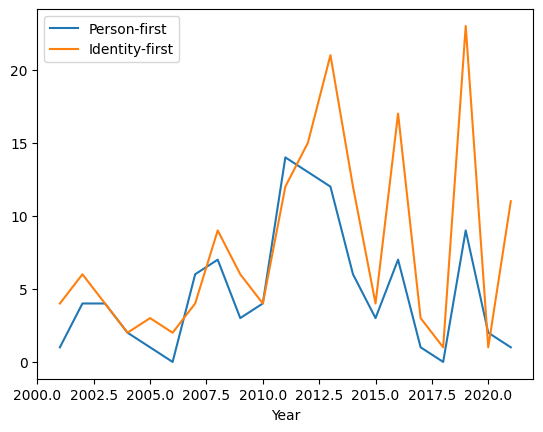

<Figure size 640x480 with 0 Axes>

In [80]:
person_identity_count.plot()
plt.show()
plt.savefig('..\\output\\matches_count.jpg')    # we can right click on the plot above to save it, or save it via command

In [63]:
person_examples = reviewed_matches.groupby(['Person-first'])['Person-first'].count()
identity_examples = reviewed_matches.groupby(['Identity-first'])['Identity-first'].count()
print(len(person_examples))
print(len(identity_examples))

27
36


In [65]:
person_identity_examples=pd.concat([person_examples,identity_examples],axis=1)


In [66]:
person_identity_examples.sort_values(by=['Person-first'], ascending=False).head(10)

,Person-first,Identity-first
patient with autism,40.0,NaN
child with autism,12.0,NaN
individual with autism,12.0,NaN
boy with autism,5.0,NaN
family with autism,3.0,NaN
girl with autism,3.0,NaN
subject with autism,2.0,NaN
people with autism,2.0,NaN
child with idiopathic autism,2.0,NaN
male with autism,2.0,NaN


In [67]:
person_identity_examples.sort_values(by=['Identity-first'], ascending=False).head(10)

,Person-first,Identity-first
ASD patient,NaN,30.0
autistic patient,NaN,21.0
autistic child,NaN,14.0
autistic individual,NaN,12.0
ASD case,NaN,10.0
ASD family,NaN,10.0
ASD subject,NaN,8.0
ASD individual,NaN,8.0
autistic group,NaN,6.0
autistic population,NaN,6.0


In [68]:
person_identity_examples.notnull().sum()

Person-first      27
Identity-first    36
dtype: int64

## Count abstracts by the structures they use

In [72]:
person_by_title = reviewed_matches.groupby(['Title'])['Person-first'].count()
identity_by_title = reviewed_matches.groupby(['Title'])['Identity-first'].count()
title = pd.concat([person_by_title,identity_by_title],axis=1)
title

,Person-first,Identity-first
Title,,
16p11.2 microdeletion and microduplication in two Lithuanian patients with speech delay,0,1
A c GH Array study in non syndromic (primary) autism disorder,1,1
A clinical study of patients with pericentromeric deletion and duplication within 16p11.2 p12.2,3,0
"A cross disorder dosage sensitivity map of the human genome Ryan Lewis Collins 1, Joseph T",1,0
A highly conserved program of neuronal microexons is misregulated in autistic brains,1,0
...,...,...
cADHERiN 11 as a possible candidate gene for autism,1,0
common variants in cadherin 10 gene show association with autism spectrum disorders in Finnish population,1,1
complex genomic structure underlying an interrupted microdeletion in 16p11.2 p12.1 with breakpoints mapping to non homologous LcRs,1,0


In [73]:
title.sort_values(by=['Identity-first'], ascending=False)

,Person-first,Identity-first
Title,,
Polymorphism in Serotonin Transporter Gene in Autism,1,5
Role of serotonin transporter promoter length polymorphism in autism: A south African population based study,0,5
PON1 phenotype and gene polymorphisms in children with autism,0,4
D Autism Spectrum Disorder: gene variants involved in the nonsense mediated mRNA decay pathway,0,4
"B Contribution of compound heterozygous CACNA1H mutations in autism spectrum disorder susceptibilityAbstracts from the 54thEuropean Society of Human Genetics (ESHG) Conference 266 European Journal of Human Genetics (2022) 30:88 â 608Marta Viggiano1, Cinzia Cameli1, Annio Posar2,3, Maria C",0,4
...,...,...
"Identification of a novel missense mutation in HUWE1 (Xp11.2) segregating with intellectual disability in a large family, by Targeted High Throughput Sequencing.",1,0
"HDAC1: a novel cause of autism, developmental delay and epilepsy",2,0
Genetic causes of pervasive developmental disorders,1,0


In [74]:
title.sort_values(by=['Person-first'], ascending=False)

,Person-first,Identity-first
Title,,
c hildren autism and mitochondrial DNA mutations,4,0
Autism s pectrum Disorders and s eizure s yndrome,4,1
A 2.2mb microduplication in 1q42.2 including DISC in 2 brothers with autism and mild mental retardation,3,0
A clinical study of patients with pericentromeric deletion and duplication within 16p11.2 p12.2,3,0
B MLPA analysis as a diagnostic test in patients withautism spectrum disorders,3,2
...,...,...
"SNP association of CNTN4, CNTN5, CNTN6, CHL1 and GRIN2B corroborates and extends copy number variation data in autism",0,3
S Three SNP haplotypes in Neuroligins may correlate to autism susceptibility,0,1
S The role of the NR2A and NR2B subunits of the NMDA receptor in epileptogenesis,0,1


In [75]:
columns = ['Person-first','Identity-first']
filter_ = (title[columns] > 0).all(axis=1)
title[filter_]
len(title[filter_])


21

In [76]:
title[filter_].sort_values(by=['Person-first'], ascending=False)

,Person-first,Identity-first
Title,,
Autism s pectrum Disorders and s eizure s yndrome,4,1
B MLPA analysis as a diagnostic test in patients withautism spectrum disorders,3,2
Two cases with different microaberrations of the long arm of chromosome 15 and autism,2,1
multiple minor congenital defects associated with autism spectrum disorders,2,2
Cytogenetic analysis in autistic disorder,2,2
Identifying phenotypes and exploring genetic aetiology of autism spectrum disorders : a 87 patient study.,1,1
Custom designed CGH array in autism spectrum disorders,1,1
common variants in cadherin 10 gene show association with autism spectrum disorders in Finnish population,1,1
Systematic evaluation of the clinical significance of inherited and de novo copy Number Variations in families with Autism spectrum Disorders,1,1


In [77]:
title[filter_].sort_values(by=['Identity-first'], ascending=False)

,Person-first,Identity-first
Title,,
Polymorphism in Serotonin Transporter Gene in Autism,1,5
No evidence for an association with the serotonin transporter gene polymorphisms (5 HTTVNTR and 5 HTTLPR) and autism,1,3
Microrrearrangements of human chromosome 15q11 q13 in families with autistic disorder,1,3
B MLPA analysis as a diagnostic test in patients withautism spectrum disorders,3,2
Abnormal growth and dysmorphic features in children with autism spectrum disorders,1,2
Frequent 22q11 aberrations in patients with non syndromic autism spectrum disorders shown by sNP array based segmental aneuploidy screening,1,2
C Genetic determinants for social skill training outcomesin autism spectrum disorder,1,2
multiple minor congenital defects associated with autism spectrum disorders,2,2
Cytogenetic analysis in autistic disorder,2,2


In [92]:
has_pf = title[title['Person-first'] > 0]
has_both = has_pf[has_pf['Identity-first'] > 0]
print(len(has_both))
has_both

21


,Person-first,Identity-first
Title,,
A c GH Array study in non syndromic (primary) autism disorder,1,1
Autism s pectrum Disorders and s eizure s yndrome,4,1
Contribution of rare and common variants of the PTCHD1 gene to Autism Spectrum Disorder and Intellectual Disability,1,2
Cytogenetic analysis in autistic disorder,2,2
Identifying phenotypes and exploring genetic aetiology of autism spectrum disorders : a 87 patient study.,1,1
Inherited and de novo SHANK2 variants associated with autism spectrum disorder impair neuronal morphogenesis and physiology,1,1
S No evidence for a contribution of CHRNA7 rare variants in autism susceptibility,1,1
Two cases with different microaberrations of the long arm of chromosome 15 and autism,2,1
A NCAM2 deletion in a patient with autism,1,1
